In [529]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [530]:
from src.acquisition import *
from src.feature_engineering import *

In [531]:
import pandas as pd 
import xgboost as xgb                                                           # gradient boosting algorithm
import optuna                                                                   # hyperparameter optimization
from catboost import CatBoostRegressor, Pool                                    # gradient boosting algorithm
import numpy as np


from sklearn.linear_model import LogisticRegression                             # linear fitting
from sklearn.ensemble import HistGradientBoostingClassifier, IsolationForest    # histogram boosting for NaN, IsolationForest?
from sklearn.cluster import KMeans                                              # K Means technique
from sklearn.neighbors import NearestNeighbors                                  # nearest neighbor 

from sklearn.model_selection import KFold, train_test_split, StratifiedGroupKFold
from sklearn.model_selection import cross_val_score, cross_val_predict  
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 15) 
pd.set_option('display.max_rows', 50)

seed = np.random.seed(578)

## 1. Data acquisition

## 1.2 $\textbf{3DSC}$ Database
$\textit{https://github.com/aimat-lab/3DSC}$ superconductor database 

In [532]:
train_path   = 'data/train.csv'
test_path    = 'data/test.csv'
crystal_path = 'data/Artificial_Crystals_Dataset.csv'
mineral_path = 'data/Mineral_Dataset_Supplementary_Info.csv'

In [533]:
train = acquisition_pipeline(path=train_path,drop_cols='id')
test = acquisition_pipeline(path=test_path)
crystal = acquisition_pipeline(path=crystal_path,drop_cols='Unnamed: 0',fill_NA_col='Crystal structure')
mineral = acquisition_pipeline(path=mineral_path,drop_cols='Unnamed: 0')

In [534]:
train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.000,0.842,10.000,4.800,20.613,11.088,2.766,1.732,0.860,0.496,0.915,6.000
1,100.000,7.558,10.000,4.800,20.299,12.041,2.755,1.631,0.910,0.493,0.718,6.500
2,76.000,8.886,15.600,5.600,33.739,12.086,2.828,1.788,0.864,0.481,1.506,2.500
3,100.000,8.795,10.000,4.800,20.213,10.948,2.648,1.626,0.936,0.489,0.789,6.000
4,116.000,9.578,11.600,4.800,24.988,11.824,2.766,1.682,0.896,0.493,1.865,6.000


In [535]:
test.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.000,121.420,35.360,5.280,82.561,9.370,2.298,1.907,1.200,0.462,1.795
1,10408,90.000,9.932,18.000,5.600,39.568,12.086,2.868,1.652,0.864,0.476,1.412
2,10409,116.000,7.768,11.600,4.800,23.232,11.024,2.644,1.794,0.960,0.500,0.788
3,10410,100.000,9.108,10.000,4.800,20.299,12.086,2.828,1.662,0.792,0.496,1.205
4,10411,55.000,4.030,11.000,4.000,22.978,11.281,2.455,1.750,0.893,0.476,0.935


## 2. Feature Engineering

In [536]:
ignore_features = ['id','Hardness','is_original']
features = [f for f in train.columns if f not in ignore_features]

In [537]:
fe_train = feature_engineering_pipeline(train,
        to_merge=mineral,                                        # merging data with mineral dataset                             
        ignore_outlier_features=ignore_features,                 # ignoring columns for outlier detection   
        outlier_col='Outlier',                                   # outlier column with True/FAlse
        std_features=features,std_method='zscore',               # standardization method applied to features
        kmeans_features=features,k_clusters=5,                   # creating new columns with closest cluster + distance to it

        )

[INFO.feature_engineering.merge_without_duplicates]: Found 23 duplicates
[INFO.feature_engineering.add_outliers_col]: Found 1128 outliers
[INFO.feature_engineering.create_kmeans_features]: Created 5 cluster cols


In [538]:
fe_train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,...,Outlier,cluster,dist_to_center_0,dist_to_center_1,dist_to_center_2,dist_to_center_3,dist_to_center_4
0,-0.128,-0.785,-0.662,0.373,-0.640,0.096,0.467,...,0,1,3.143,0.948,4.852,44.618,16.974
1,-0.128,-0.419,-0.662,0.373,-0.652,0.771,0.434,...,0,1,2.967,0.998,5.030,44.440,17.100
2,-0.208,-0.346,-0.126,1.529,-0.135,0.803,0.652,...,0,1,4.045,1.524,4.723,44.493,17.994
3,-0.128,-0.351,-0.662,0.373,-0.656,-0.003,0.114,...,0,1,3.176,0.902,4.659,44.446,16.605
4,-0.075,-0.309,-0.509,0.373,-0.472,0.618,0.467,...,0,1,3.094,0.581,4.542,44.355,17.174


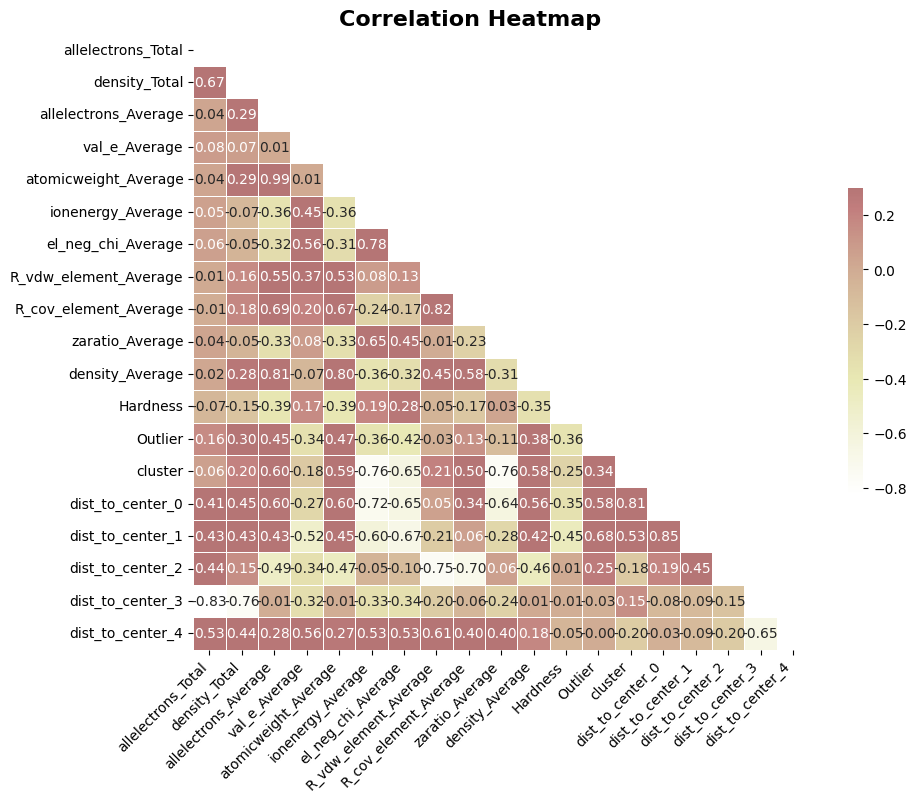

In [539]:
corr = fe_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Correlation Heatmap", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

## 2.1 Train Test Split

In [540]:
y = fe_train['Hardness'].values
X = fe_train.drop(columns=['Hardness'])

In [541]:
X_train, X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=seed)

## 3. Model selection

In [542]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
models = {
    'LR' : LinearRegression(),
    'XGB': XGBRegressor(random_state=seed),
    'CAT': CatBoostRegressor(random_state=seed),
    # 'GB': GradientBoostingRegressor(random_state=seed),
    # 'LGB': LGBMRegressor(random_state=seed),
}


param_grids = {
    
    'LR': {
    },

    'XGB': {
        'max_depth': [3],
        'learning_rate': [0.06],
        'n_estimators': [270],
        'eval_metric': ['rmse'],
        'tree_method': ['exact'],
        'sampling_method':['uniform'],
        'subsample': [0.7],
        'colsample_bytree': [0.9],
        'reg_lambda': [0.2],
    },
    'GB': {
        'loss': ['huber'],
        'learning_rate': [0.07],
        'n_estimators' :[270],
        'max_depth':[3]
    },
    'LGB': {
        'num_leaves': [31],
        'learning_rate':[0.08],
        'n_estimators': [100],
        'objective': ['regression_l1'],
        'force_col_wise': [True],
        'boost': ['gbdt'],
        'subsample_for_bin':[800],
        'colsample_bytree': [0.9],
        'reg_lambda': [0.1],
    },
    'CAT': {
        'verbose': [False],
        'random_seed': [42],
        'iterations': [3000],
        'loss_function': ['Quantile:alpha=0.5'],
        'depth': [7],
        'subsample':[0.7841394148733731],
        'learning_rate': [0.04442655333145627],
        'l2_leaf_reg': [3.523614847869309],
        'leaf_estimation_method': ['Exact'],
        'boost_from_average': [True],
    }
}


## 4. Training and Validation

In [543]:
best_models = {}
best_score = float('inf')

In [544]:
import contextlib

for model_name, model in models.items():
    param_grid = param_grids[model_name]

    with contextlib.redirect_stdout(None):
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=5,
            scoring='neg_median_absolute_error',
            verbose=False,
            return_train_score=True,
        )

        grid_search.fit(X_train, y_train)
        cv_results = grid_search.cv_results_

    best_models[model_name] = grid_search.best_estimator_

    # pretty-print model configurations
    print("=" * 170)
    for i, params in enumerate(cv_results['params']):
        score = abs(cv_results['mean_test_score'][i])
        print(f"[{model_name}]:\t{score}\t\t{params}\t")

[LR]:	0.8245195549771942		{}	
[XGB]:	0.6937742328643799		{'colsample_bytree': 0.9, 'eval_metric': 'rmse', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 270, 'reg_lambda': 0.2, 'sampling_method': 'uniform', 'subsample': 0.7, 'tree_method': 'exact'}	
[CAT]:	0.5510501106678044		{'boost_from_average': True, 'depth': 7, 'iterations': 3000, 'l2_leaf_reg': 3.523614847869309, 'leaf_estimation_method': 'Exact', 'learning_rate': 0.04442655333145627, 'loss_function': 'Quantile:alpha=0.5', 'random_seed': 42, 'subsample': 0.7841394148733731, 'verbose': False}	


In [545]:
ensemble_clf = VotingRegressor(
    estimators=[
        ('LR',best_models['LR']),
        ('XGB',best_models['XGB']),
        ('CAT',best_models['CAT']),
    #     ('GB',best_models['GB']),
    #     ('LGB',best_models['LGB']),
    ],
    weights=[0.1, 0.3, 0.6],
    verbose=True
)

## 4.2 Validation

In [546]:
ensemble_clf.fit(X_train,y_train)

[Voting] ....................... (1 of 3) Processing LR, total=   0.0s
[Voting] ...................... (2 of 3) Processing XGB, total=   0.7s
[Voting] ...................... (3 of 3) Processing CAT, total=  19.1s


VotingRegressor(estimators=[('LR', LinearRegression()),
                            ('XGB',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.9, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_con...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=270,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('CAT',
                             <catboost.core.CatBoostRegressor object at 0x000002A1EB1A9C90>)],
                verbose=True, weights=[0.1, 0.3, 0.6])

In [547]:
print("[MedAE]:\t\t", ensemble_clf.score(X_val,y_val))

[MedAE]:		 0.5099180693206284


## 5. Test Preparation

In [553]:
ids = test['id']
test = test.drop(columns='id')

In [554]:
fe_test = feature_engineering_pipeline(test,
        ignore_outlier_features=ignore_features,                 # ignoring columns for outlier detection   
        outlier_col='Outlier',                                   # outlier column with True/FAlse
        std_features=features,std_method='zscore',               # standardization method applied to features
        kmeans_features=features,k_clusters=5,                   # creating new columns with closest cluster + distance to it
)

[INFO.feature_engineering.add_outliers_col]: Found 989 outliers
[INFO.feature_engineering.create_kmeans_features]: Created 5 cluster cols


In [555]:
test_preds = ensemble_clf.predict(fe_test)

## Kaggle submission

In [556]:
submission_data = np.column_stack((ids,test_preds))
np.savetxt('data/submission.csv', submission_data, delimiter=',', header='id,Hardness', fmt='%d,%.4f', comments='')